In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import skewnorm, gaussian_kde
from concurrent.futures import ProcessPoolExecutor
from twoprocess import TwoProcessModel
from twoprocess import generate_population_params
from twoprocess import phase_light, worker_simulation
import math
from statistics import median
import config
import os
import importlib

# Reload the module to apply changes made since the last import
importlib.reload(config)
from config import CONFIG
CONFIG['bio_params']


{'a': 0.05,
 'lag': 4.71238898038469,
 'alpha': 5.105088062083413,
 'Hu0': 0.71,
 'Hl0': 0.2,
 'K': 0.1,
 'sigma': 0.005}

In [2]:
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.titlesize": 11,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": False,
})

In [3]:

# ==============================================================================
# 1. Generate Data
np.random.seed(172)
population_params = generate_population_params(config=CONFIG)

# 2. Simulate in Parallel
print(f"Starting parallel simulation for {CONFIG['sample_size']} agents...")
with ProcessPoolExecutor(max_workers=15) as executor:
    results = list(executor.map(worker_simulation, population_params))

all_traces, all_stats = zip(*results)
# Flatten Chronotypes for Histogram/Analysis later
flat_chronotypes = pd.concat(all_stats)['Chronotype'].reset_index(drop=True)

# phi_light_list = np.array([
#     phase_light(t, CONFIG['end'], CONFIG['start'], CONFIG['bio_params']['lag']) 
#     for t in CONFIG['time_arr']
# ])


# # Calculate light_list based on phi_light_list
# light_list = CONFIG['bio_params']['a'] * np.sin(phi_light_list) + CONFIG['bio_params']['Hu0'] 


Generating population parameters...
Starting parallel simulation for 1000 agents...


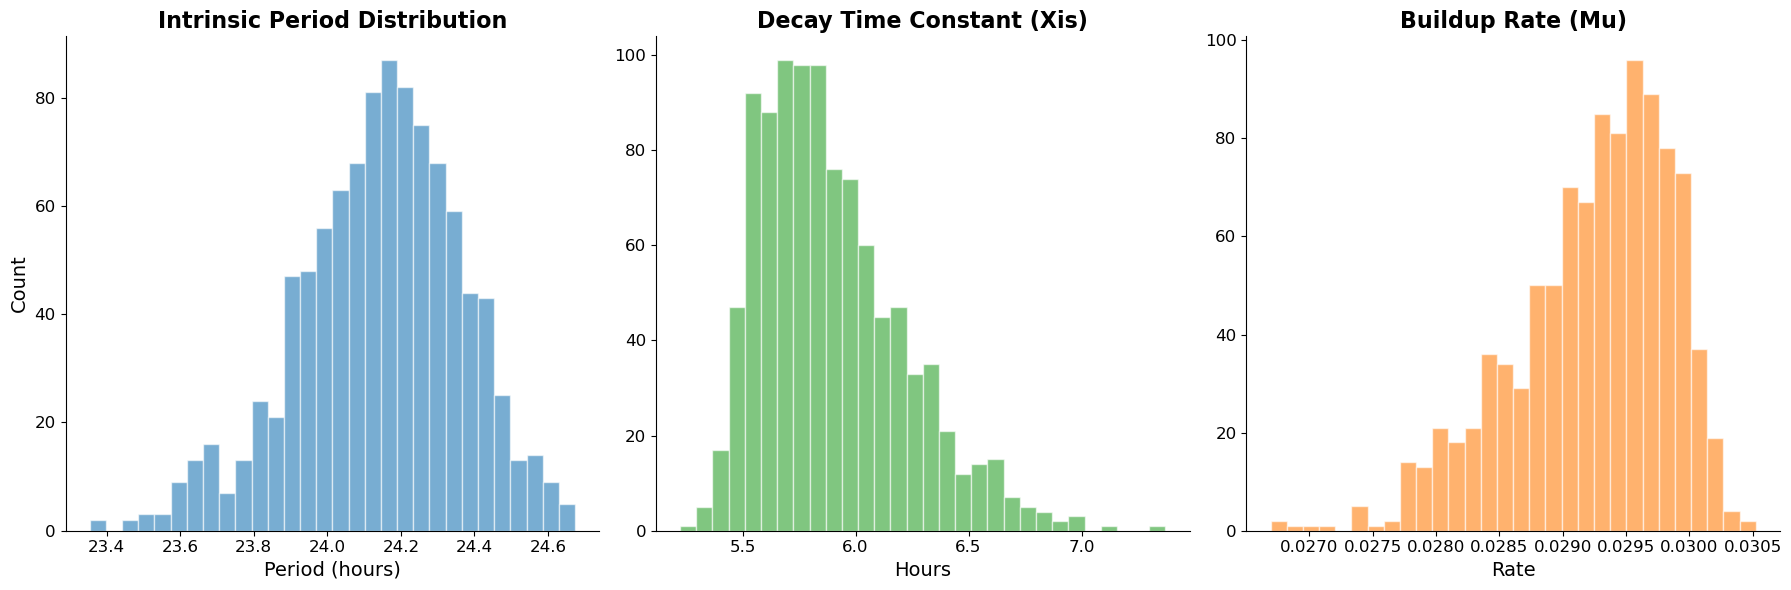

--- Population Statistics ---
            period          Xis           mu
count  1000.000000  1000.000000  1000.000000
mean     24.142371     5.894082     0.029235
std       0.222797     0.319846     0.000625
min      23.353940     5.224013     0.026694
25%      24.005405     5.653513     0.028874
50%      24.159581     5.829659     0.029348
75%      24.297731     6.070503     0.029698
max      24.673876     7.371138     0.030524


In [4]:

# 1. Convert to DataFrame for easy analysis
df_params = pd.DataFrame(population_params)

# 2. Plot Histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# A. Intrinsic Period (Tau)
axes[0].hist(df_params['period'], bins=30, color='tab:blue', alpha=0.6, edgecolor='white')
axes[0].set_title('Intrinsic Period Distribution', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Period (hours)', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)

# B. Homeostatic Decay (Xis)
axes[1].hist(df_params['Xis'], bins=30, color='tab:green', alpha=0.6, edgecolor='white')
axes[1].set_title('Decay Time Constant (Xis)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Hours', fontsize=14)

# C. Homeostatic Buildup (Mu)
axes[2].hist(df_params['mu'], bins=30, color='tab:orange', alpha=0.6, edgecolor='white')
axes[2].set_title('Buildup Rate (Mu)', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Rate', fontsize=14)

# Common Styling
for ax in axes:
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# Print Summary Stats
print("--- Population Statistics ---")
print(df_params.describe()[['period', 'Xis', 'mu']])

C:\Users\Admin\AppData\Local\Temp\ipykernel_12012\817725747.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


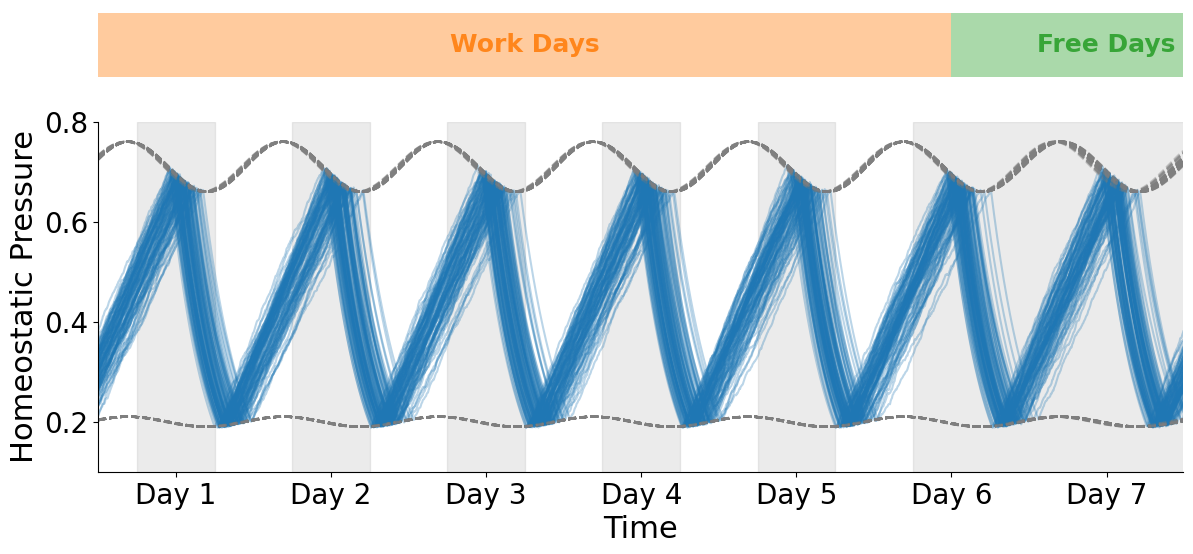

In [ ]:
# --- Plotting Setup ---
fig, (ax_bar, ax_main) = plt.subplots(
    2, 1, figsize=(14, 6), sharex=True, gridspec_kw={'height_ratios': [1, 5], 'wspace': 0.05}
)

# 1. Define Window
start_hour = 6.5 * 24
end_hour = CONFIG['time_arr'].max() - 12 # Or define a specific end point like 13.5 * 24

# Find index
start_idx = np.searchsorted(CONFIG['time_arr'], start_hour)

# ==============================================================================
# A. BAR PLOT (Work Days / Free Days)
# ==============================================================================
# Work Days (5.5 days) followed by Free Days (remaining)
bar_starts = [start_hour, start_hour + (24 * 5.5)]
bar_widths = [24 * 5.5, 24 * 2] 
bar_labels = ['Work Days', 'Free Days']
bar_colors = ['tab:orange', 'tab:green']

for i in range(2):
    # Bars
    ax_bar.barh(
        y=0, width=bar_widths[i], left=bar_starts[i], height=0.6, 
        color=bar_colors[i], alpha=0.4
    )
    # Labels
    x_center = bar_starts[i] + bar_widths[i] / 2
    ax_bar.text(
        x_center, 0, bar_labels[i],
        ha='center', va='center', fontsize=18, fontweight='bold',
        color=bar_colors[i], alpha=0.9
    )

# Turn off the axis lines/ticks for the bar plot completely
ax_bar.axis('off')
ax_bar.set_xlim(start_hour, end_hour)

# ==============================================================================
# B. MAIN TRACES
# ==============================================================================
plot_n = min(CONFIG['plot_n_agents'], CONFIG['sample_size'])

for i in range(plot_n):
    df_trace = all_traces[i]
    
    # Slice data
    time_slice = df_trace['time'][start_idx:]
    h_slice = df_trace['H'][start_idx:]
    u_slice = df_trace['upper'][start_idx:]
    l_slice = df_trace['lower'][start_idx:]
    
    # Legend labels (First agent only)
    lbl_h = 'Sleep Homeostasis' if i == 0 else ""
    lbl_u = 'Sleep Threshold' if i == 0 else ""
    lbl_l = 'Wake Threshold' if i == 0 else ""
    
    ax_main.plot(time_slice, h_slice, color='tab:blue', alpha=0.3, label=lbl_h)
    ax_main.plot(time_slice, u_slice, color='tab:gray', linestyle='--', alpha=0.3, label=lbl_u)
    ax_main.plot(time_slice, l_slice, color='tab:gray', linestyle='--', alpha=0.3, label=lbl_l)

# ==============================================================================
# C. SHADING (Dynamic)
# ==============================================================================
night_start_hour = 18 
night_duration = 12   

start_day_idx = int(start_hour // 24)
# Ensure we cover enough days to fill the plot
end_day_idx = int(end_hour // 24) -3

for day in range(start_day_idx, end_day_idx + 1):
    t_start = day * 24 + night_start_hour
    t_end = t_start + night_duration
    
    # Draw if overlaps with view
    if t_end > start_hour and t_start < end_hour:
        label_night = 'Night' if day == start_day_idx else ""
        ax_main.axvspan(t_start, t_end, color='tab:gray', alpha=0.15, label=label_night)
ax_main.axvspan(288-6, 288+48, color = 'tab:gray', alpha = 0.15)

# ==============================================================================
# D. STYLING & TICKS
# ==============================================================================
ax_main.set_xlabel('Time', fontsize=22)
ax_main.set_ylabel('Homeostatic Pressure', fontsize=22)
ax_main.spines[['right', 'top']].set_visible(False)

# Limits
ax_main.set_xlim(start_hour, end_hour)
ax_main.set_ylim(0.1, 0.8)

# Ticks: Align to Midnights
# Start at the first midnight *after* start_hour
tick_start = (int(start_hour) // 24 + 1) * 24
tick_positions = np.arange(tick_start, end_hour + 1, 24)

ax_main.set_xticks(tick_positions)
# Generate labels dynamically based on the number of ticks found
ax_main.set_xticklabels([f'Day {i}' for i in range(1, len(tick_positions) + 1)])

ax_main.tick_params(axis='x', labelsize=20, rotation=0)
ax_main.tick_params(axis='y', labelsize=20)

# Optional: Legend (Commented out as per your code)
# ax_main.legend(fontsize=16, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

After filtering - work_day_chrono length: 998, period_workday length: 998


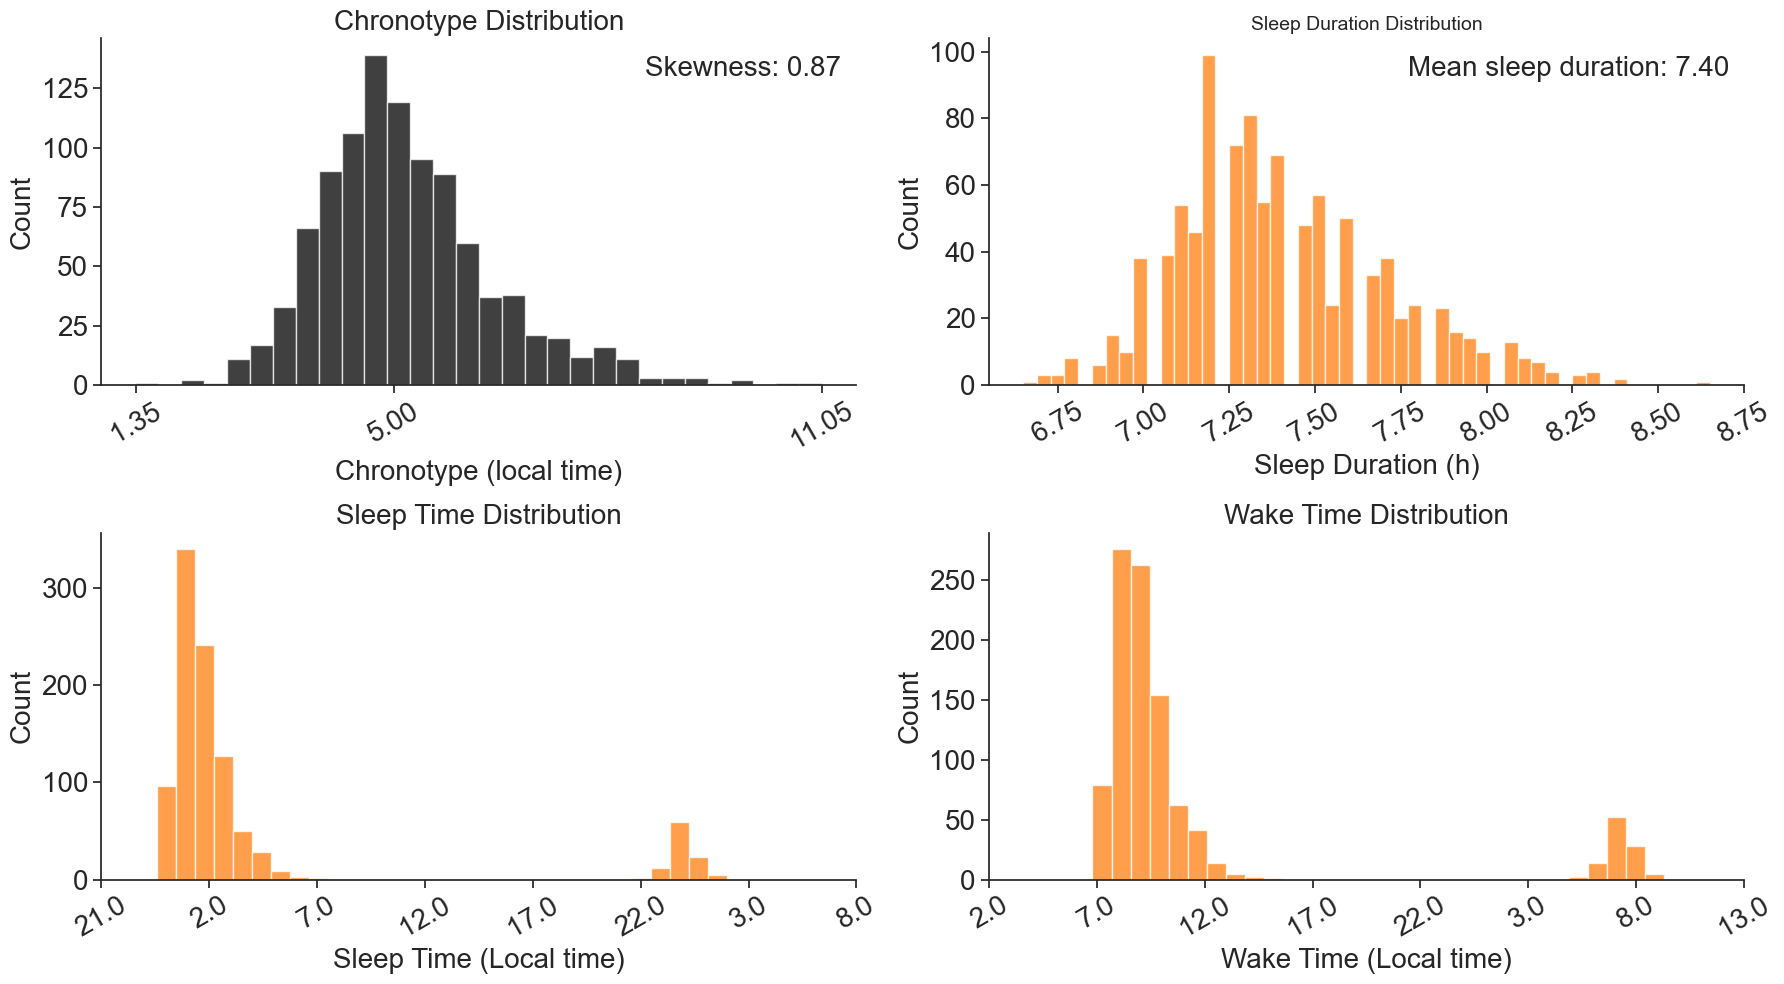

In [ ]:

# 1. Extract Data
# Convert list of DataFrames (all_stats) to list of arrays
chronotypes = [df['Chronotype'].values for df in all_stats]
work_day_indices = [0,1]

# 2. Initialize lists to store agent means
chrono_means = []
duration_means = []
sleep_means = []
wake_means = []
period_means = []

# 3. Iterate through all agents
# all_stats is a list of DataFrames (one per agent)
# population_params is a list of dicts (one per agent)

for i, df in enumerate(all_stats):
    if df.empty:
        continue

    # Ensure Sleep_Duration exists (Wake - Sleep)
    # Working on a copy to avoid side-effects
    df_calc = df.copy()
    if 'Sleep_Duration' not in df_calc.columns:
        df_calc['Sleep_Duration'] = df_calc['Wake_Onset'] - df_calc['Sleep_Onset']

    # Get Intrinsic period
    p_val = population_params[i]['period']

    # Lists for this agent
    c_list = []
    d_list = []
    s_list = []
    w_list = []
    
    # Collect data for specific work day cycles
    for cycle in work_day_indices:
        if cycle < len(df_calc):
            # Chronotype
            c_list.append(df_calc['Chronotype'].iloc[cycle])
            
            # Duration
            d_list.append(df_calc['Sleep_Duration'].iloc[cycle])
            
            # Local Sleep Time (Sleep Onset - 24*cycle)
            s_val = df_calc['Sleep_Onset'].iloc[cycle] - (24 * cycle)
            s_list.append(s_val)
            
            # Local Wake Time (Wake Onset - 24*cycle)
            w_val = df_calc['Wake_Onset'].iloc[cycle] - (24 * cycle)
            w_list.append(w_val)
    
    # Calculate means for this agent (if valid data exists)
    if c_list:
        chrono_means.append(np.mean(c_list))
        duration_means.append(np.mean(d_list))
        sleep_means.append(np.mean(s_list))
        wake_means.append(np.mean(w_list))
        period_means.append(p_val)

# Convert to numpy arrays for vectorized filtering
work_day_chrono = np.array(chrono_means)
sleep_duration = np.array(duration_means)
sleep_time = np.array(sleep_means)
wake_time = np.array(wake_means)
period_workday = np.array(period_means)

# --- 4. Outlier Removal (Step-by-Step) ---

# A. Filter based on Chronotype (5th to 75th percentile + 1.5IQR)
# Note: Using 5th percentile for lower bound as per your code
q1 = np.percentile(work_day_chrono, 0) 
q3 = np.percentile(work_day_chrono, 99.8)
lower_bound = q1 
upper_bound = q3 

mask = (work_day_chrono >= lower_bound) & (work_day_chrono <= upper_bound)
# Apply mask to all related arrays
work_day_chrono = work_day_chrono[mask]
sleep_duration = sleep_duration[mask]
sleep_time = sleep_time[mask]
wake_time = wake_time[mask]
period_workday = period_workday[mask]

# Debug: Check lengths are equal after filtering
print(f"After filtering - work_day_chrono length: {len(work_day_chrono)}, period_workday length: {len(period_workday)}")
assert len(work_day_chrono) == len(period_workday), "Length mismatch! Arrays should be equal after filtering."

# Stats for plotting
sleep_mean = np.mean(sleep_duration)

# --- 5. Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# [0, 0] Chronotype Histogram
axs[0, 0].hist(work_day_chrono, bins=30, alpha=0.75, color='black', edgecolor='white')
axs[0, 0].set_xlabel('Chronotype (local time)', fontsize=20)
axs[0, 0].set_ylabel('Count', fontsize=20)
axs[0, 0].set_title('Chronotype Distribution', fontsize=20)
axs[0, 0].spines[['right','top']].set_visible(False)

# Skewness Label
skewness = stats.skew(work_day_chrono)
axs[0, 0].text(
    0.98, 0.95, f"Skewness: {skewness:.2f}",
    transform=axs[0, 0].transAxes, fontsize=20,
    verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)
# Ticks: Min, Max, Median
c_min, c_max = min(work_day_chrono), max(work_day_chrono)
c_med = median(work_day_chrono)
axs[0, 0].set_xticks([c_min, c_max, c_med])
axs[0, 0].set_xticklabels([f"{x:.2f}" for x in [c_min, c_max, c_med]])
axs[0, 0].tick_params(axis='x', labelsize=20, rotation=30)
axs[0, 0].tick_params(axis='y', labelsize=20)


# [0, 1] Sleep Duration Histogram
axs[0, 1].hist(sleep_duration, bins=50, alpha=0.75, color='tab:orange', edgecolor='white')
axs[0, 1].set_xlabel('Sleep Duration (h)', fontsize=20)
axs[0, 1].set_ylabel('Count', fontsize=20)
axs[0, 1].set_title('Sleep Duration Distribution', fontsize=14)
axs[0, 1].spines[['right','top']].set_visible(False)

# Mean Label
axs[0, 1].text(
    0.98, 0.95, f"Mean sleep duration: {sleep_mean:.2f}",
    transform=axs[0, 1].transAxes, fontsize=20,
    verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)
axs[0, 1].tick_params(axis='x', labelsize=20, rotation=30)
axs[0, 1].tick_params(axis='y', labelsize=20)


# [1, 0] Sleep Time Histogram
axs[1, 0].hist(sleep_time, bins=30, alpha=0.75, color='tab:orange', edgecolor='white')
axs[1, 0].set_xlabel('Sleep Time (Local time)', fontsize=20)
axs[1, 0].set_ylabel('Count', fontsize=20)
axs[1, 0].set_title('Sleep Time Distribution', fontsize=20)
axs[1, 0].spines[['right','top']].set_visible(False)

# Modulo 24 Ticks
xticks_mod = np.array(axs[1, 0].get_xticks())
axs[1, 0].set_xticks(xticks_mod)
axs[1, 0].set_xticklabels([f"{label % 24:.1f}" for label in xticks_mod], rotation=30, fontsize=10)
axs[1, 0].tick_params(axis='x', labelsize=20, rotation=30)
axs[1, 0].tick_params(axis='y', labelsize=20)


# [1, 1] Wake Time Histogram
axs[1, 1].hist(wake_time, bins=30, alpha=0.75, color='tab:orange', edgecolor='white')
axs[1, 1].set_xlabel('Wake Time (Local time)', fontsize=20)
axs[1, 1].set_ylabel('Count', fontsize=20)
axs[1, 1].set_title('Wake Time Distribution', fontsize=20)
axs[1, 1].spines[['right','top']].set_visible(False)

# Modulo 24 Ticks
xticks_mod = np.array(axs[1, 1].get_xticks())
axs[1, 1].set_xticks(xticks_mod)
axs[1, 1].set_xticklabels([f"{label % 24:.1f}" for label in xticks_mod], rotation=30, fontsize=10)
axs[1, 1].tick_params(axis='x', labelsize=20, rotation=30)
axs[1, 1].tick_params(axis='y', labelsize=20)


# plt.suptitle("Work day sleep data", fontsize=16, fontweight='bold')
# plt.savefig("supplement.png",dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
np.save('final chronotype.npy', work_day_chrono)
np.save ('period.npy', period_workday)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12012\2827858133.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<function matplotlib.pyplot.show(close=None, block=None)>

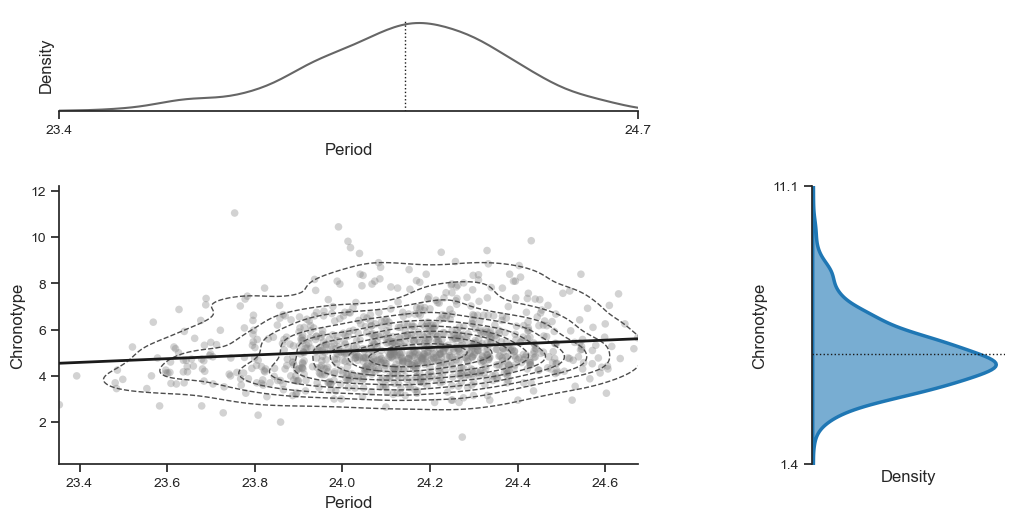

In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import seaborn as sns

def plot_joint_with_shapes(ax, X, Y, case_id):
    """
    ax: main axis allocated for column 3
    case_id: 0..3 (used to vary style across rows)
    """

    # -----------------------------
    # Create inset axes
    # -----------------------------
    ax_joint = inset_axes(
        ax, width="60%", height="60%",
        loc="lower left", borderpad=0.6
    )
    ax_top = inset_axes(
        ax, width="60%", height="20%",
        loc="upper left", borderpad=0.6
    )
    ax_right = inset_axes(
        ax, width="20%", height="60%",
        loc="lower right", borderpad=0.6
    )

    # -----------------------------
    # Style per case
    # -----------------------------
    contour_levels = [5, 10, 15, 20]
    linestyles = ["solid", "dashed", "solid", "dashed"]

    # -----------------------------
    # Scatter (raw data)
    # -----------------------------
    ax_joint.scatter(
        X, Y,
        s=30,
        color="0.5",
        alpha=0.35,
        edgecolor="none",
        zorder=1
    )

    # -----------------------------
    # Correlation / regression line
    # -----------------------------
    m, b = np.polyfit(X, Y, 1)
    xx = np.linspace(np.min(X), np.max(X), 200)
    yy = m * xx + b

    ax_joint.plot(
        xx, yy,
        color="k",
        lw=2,
        zorder=3
    )

    # -----------------------------
    # Joint KDE contours (context)
    # -----------------------------
    sns.kdeplot(
        x=X, y=Y,
        levels=contour_levels[case_id],
        color="0.3",
        linewidths=1,
        linestyles=linestyles[case_id],
        ax=ax_joint,
        zorder=2
    )

    ax_joint.set_xlabel("Period", fontsize=12)
    ax_joint.set_ylabel("Chronotype", fontsize=12)
    ax_joint.tick_params(labelsize=10)
    sns.despine(ax=ax_joint)
    

    # -----------------------------
    # Period distribution (top)
    # -----------------------------
    sns.kdeplot(
        x=X,
        color="0.4",
        lw=1.5,
        ax=ax_top
    )

    xmin, xmax = np.min(X), np.max(X)
    ax_top.set_xlim(xmin, xmax)
    ax_top.set_xticks([xmin, xmax])
    ax_joint.set_xlim(xmin, xmax)
    ax_top.set_xticklabels(
        [f"{xmin:.1f}", f"{xmax:.1f}"], fontsize=10
    )
    ax_top.set_yticks([])
    ax_top.set_xlabel("Period", fontsize=12)
    ax_top.axvline(np.mean(X), color="k", lw=1, ls=":")
    sns.despine(ax=ax_top, left=True)

    # -----------------------------
    # Chronotype distribution (right)
    # -----------------------------
    sns.kdeplot(
        y=Y,
        fill=True,
        alpha=0.6,
        lw=2.5,
        color="tab:blue",
        ax=ax_right
    )

    ymin, ymax = np.min(Y), np.max(Y)
    ax_right.set_ylim(ymin, ymax)
    ax_right.set_yticks([ymin, ymax])
    ax_right.set_yticklabels(
        [f"{ymin:.1f}", f"{ymax:.1f}"], fontsize=10
    )
    ax_right.set_xticks([])
    ax_right.set_ylabel("Chronotype", fontsize=12)

    ax_right.axhline(np.mean(Y), color="k", lw=1, ls=":")
    sns.despine(ax=ax_right, bottom=True)
    # plt.tight_layout()

    # -----------------------------
    # Turn off parent axis
    # -----------------------------
    ax.axis("off")
    
cycle_data = work_day_chrono
periods = period_workday
fig, ax=plt.subplots(
    1, 1, figsize=(10, 5),gridspec_kw={'hspace':0,'wspace':0})
plot_joint_with_shapes(X= periods, Y= work_day_chrono, ax=ax, case_id=1)
plt.tight_layout()
plt.savefig ('correlation.svg', bbox_inches = 'tight', transparent  = True)
plt.show

C:\Users\Admin\AppData\Local\Temp\ipykernel_12012\1234379031.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


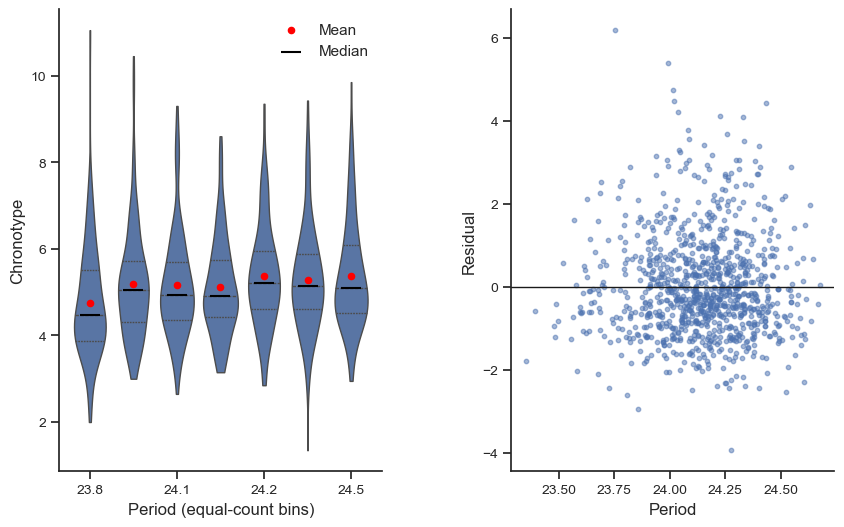

In [40]:
# -------------------------
df = pd.DataFrame({'Period': periods, 'Chronotype': work_day_chrono})
df["Bin"] = pd.qcut(df["Period"], q=7, labels=False)
bin_centers = df.groupby("Bin")["Period"].mean()
fig, axes=plt.subplots(
    1, 2, figsize=(10, 6),gridspec_kw={'hspace':0.4,'wspace':0.4})    
# Column 1: Violin plots
    # -------------------------
ax = axes[0]
sns.violinplot(
    data=df,
    x="Bin",
    y="Chronotype",
    inner="quartile",
    cut=0,
    linewidth=1,
    ax=ax
)

# Overlay mean & median
g = df.groupby("Bin")["Chronotype"]
ax.scatter(
    np.arange(len(g.mean())),
    g.mean(),
    c="red",
    s=20,
    zorder=3,
    label="Mean"
)
ax.scatter(
    np.arange(len(g.median())),
    g.median(),
    c="black",
    marker="_",
    s=200,
    zorder=3,
    label="Median"
)

ax.set_xticks(range(len(bin_centers))[::2])
ax.tick_params(labelsize = 10)
ax.set_xticklabels([f"{v:.1f}" for v in bin_centers][::2])
ax.set_xlabel("Period (equal-count bins)", fontsize = 12)
ax.set_ylabel("Chronotype", fontsize = 12)
ax.spines[['right', 'top']].set_visible(False)

# ax.set_title(title, loc="left")

ax.legend(frameon=False)

# -------------------------
# Column 2: Residuals
# -------------------------
ax = axes[1]
X = periods
Y = work_day_chrono
coef = np.polyfit(X, Y, 1)
resid = Y - (coef[0] * X + coef[1])

ax.scatter(X, resid, s=10, alpha=0.5)
ax.axhline(0, color="k", lw=1)
ax.tick_params(labelsize = 10)
ax.set_xlabel("Period", fontsize = 12)
ax.set_ylabel("Residual", fontsize = 12)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('violin.svg', bbox_inches = 'tight', transparent = True)
plt.show()